# Tutorial 3.1: Optimization and Initialization

In this tutorial, we will review techniques for optimization and initialization of neural networks. When increasing the depth of neural networks, there are various challenges we face. Most importantly, we need to have a stable gradient flow through the network, as otherwise we might encounter vanishing or exploding gradients. This is why we will take a closer look at the following concepts: initialization and optimization.

In the first half of the notebook, we will review different initialization techniques, and go step by step from the most simplest initialization to methods that are nowadays used in very deep networks. In the second half, we focus on optimization comparing the optimizers SGD, SGD with Momentum and Adam. 

Let's start with importing our standard libraries:

In [2]:
## Standard libraries
import os
import json
import math
import numpy as np 
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial3"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


## Preparation

Throughout this notebook, we will use a deep fully connected network, similar to our previous tutorial. We will also again apply the network to FashionMNIST, so you can relate to the results of Tutorial 2. 

We start by loading the FashionMNIST dataset:

In [4]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2861,), (0.3530))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

The normalization transformation `transforms.Normalize` is designed to give us an expected mean of 0 and standard deviation of 1 across pixels. You can calculate these parameters by determining the mean and standard deviation on the original images:

In [6]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.2860923707485199
Std 0.3530242443084717


We can verify the transformation by looking at the statistics of a single batch:

In [5]:
imgs, _ = next(iter(train_loader))
print("Mean: %5.3f" % imgs.mean().item())
print("Standard deviation: %5.3f" % imgs.std().item())
print("Maximum: %5.3f" % imgs.max().item())
print("Minimum: %5.3f" % imgs.min().item())

Mean: 0.002
Standard deviation: 1.001
Maximum: 2.022
Minimum: -0.810


Note that the maximum and minimum are not 1 and -1 anymore, but shifted towards the positive values. This is because FashionMNIST contains a lot of black pixels, similar to MNIST.

Next, we create our linear neural network. We use the same setup as in the previous tutorial. 

In [6]:
class BaseNetwork(nn.Module):
    
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()
        
        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.ModuleList(layers)
        
        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes} 
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = l(x)
        return x

For the activation functions, we make use of PyTorch's `torch.nn` library instead of implementing ourselves. However, we also define an `Identity` activation function. Although this activation function would significantly limit the network's modeling capabilities, we will use it in the first steps of our discussion about initialization (for simplicity). 

In [7]:
class Identity(nn.Module):
    def forward(self, x):
        return x
    
act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

Finally, we define a few plotting functions that we will use for our discussions. These functions help us to (1) visualize the weight/parameter distribution inside a network, (2) visualize the gradients that the parameters at different layers receive, and (3) the activations, i.e. the output of the linear layers. The detailed code is not important, but feel free to take a closer look if interested.

In [8]:
##############################################################

def plot_dists(val_dict, color="C0"):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.distplot(val_dict[key], ax=key_ax, color=color,
                     kde=((val_dict[key].max()-val_dict[key].min())>1e-15)) # Only plot kde if there is variance
        key_ax.set_title("%s " % key + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        fig_index += 1
    fig.subplots_adjust(wspace=0.3)
    return fig
 
##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        weights["Layer %s" % name.split(".")[1]] = param.detach().cpu().numpy()
    
    ## Plotting
    fig = plot_dists(weights, color)
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
##############################################################
    
def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels)
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()
    
    ## Plotting
    fig = plot_dists(grads, color=color)
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(grads.keys()):
            print("%s - Variance: %f" % (key, np.var(grads[key])))

##############################################################

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)
    
    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations["Layer %i" % layer_index] = feats.view(-1).detach().cpu().numpy()
    
    ## Plotting
    fig = plot_dists(activations, color=color)
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close() 
    
    if print_variance:
        for key in sorted(activations.keys()):
            print("%s - Variance: %f" % (key, np.var(activations[key])))

            
##############################################################

## Initialization

Before starting our discussion about initialization, it should be noted that there exist many very good blog posts about the topic of neural network initialization (for example [deeplearning.ai](https://www.deeplearning.ai/ai-notes/initialization/)). In case something remains unclear after this tutorial, we recommend skimming through these blog posts as well.

When initializing a neural network, there are a few properties we would like to have. First, the variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons. If the variance would vanish the deeper we go in our model, the harder it becomes to optimize the model as the input to the next layer is basically a single constant value. Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model. The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties on choosing an appropriate learning rate. 

As a starting point for finding a good method, we will analyse different initialization based on our linear neural network with no activation function (i.e. an identity). We do this because initializations depend on the specific activation function used in the network, and we can adjust the initialization schemes later on for our specific choice.

In [9]:
model = BaseNetwork(act_fn=Identity()).to(device)

### Constant initialization

The first initialization we can consider is to initialize all weights with the same constant value. Intuitively, setting all weights to zero is not a good idea as the propagated gradient will be zero. However, what happens if we set all weights to a value slightly larger or smaller than 0? To find out, we can implement a function for setting all parameters below, and visualize the gradients.

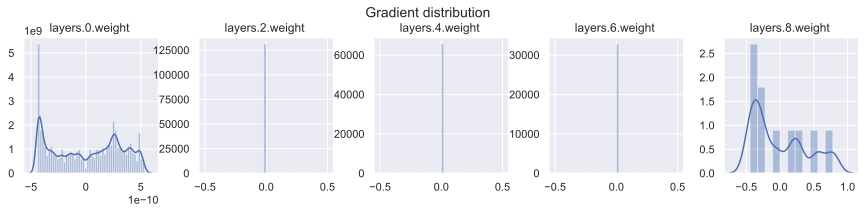

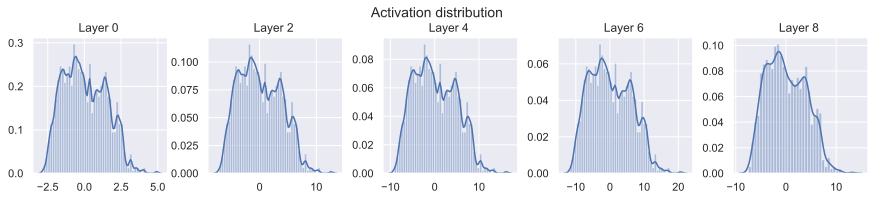

Layer 0 - Variance: 2.058276
Layer 2 - Variance: 13.489119
Layer 4 - Variance: 22.100567
Layer 6 - Variance: 36.209572
Layer 8 - Variance: 14.831439


In [11]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

As we can see, only the first and the last layer have diverse gradient distributions while the other three layers have the same gradient for all weights (note that this value is unequals 0, but often very close to it). Having the same gradient for parameters that have been initializated with the same values means that we will always have the same value for those parameters. This would make our layer useless and reduce our effective number of parameters to 1. Thus, we cannot use a constant initialization to train our networks.

### Constant variance

From the experiment above, we have seen that a constant value is not working. So instead, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian? The most intuitive way would be to choose one variance that is used for all layers in the network. Let's implement it below, and visualize the activation distribution across layers.

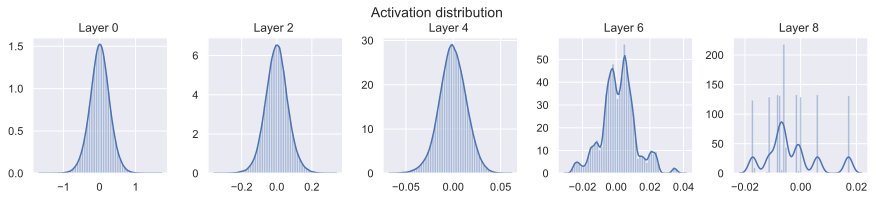

Layer 0 - Variance: 0.077930
Layer 2 - Variance: 0.004179
Layer 4 - Variance: 0.000207
Layer 6 - Variance: 0.000102
Layer 8 - Variance: 0.000083


In [12]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)
        
var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

The variance of the activation becomes smaller and smaller across layers, and almost vanishes in the last layer. Alternatively, we could use a higher standard deviation:

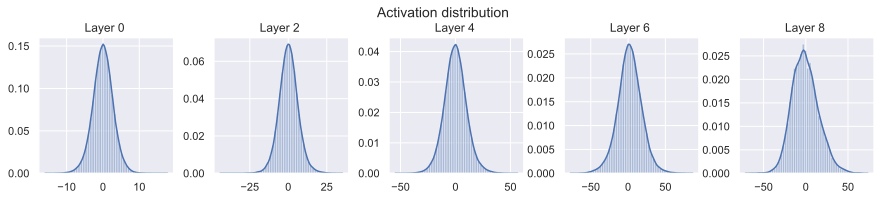

Layer 0 - Variance: 7.901733
Layer 2 - Variance: 38.941471
Layer 4 - Variance: 103.246284
Layer 6 - Variance: 262.478546
Layer 8 - Variance: 248.354202


In [13]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

With a higher standard deviation, the activations are likely to explode. You can play around with the specific standard deviation values, but it will be hard to find one that gives us a good activation distribution across layers, and is very specific to our model. If we would change the hidden sizes or number of layers, you would have to search all over again, which is neither efficient nor recommended.

### How to find appropriate initialization values

From our experiments above, we have seen that we need to sample the weights from a distribution, but are not sure which one exactly. As a next step, we will try to find the optimal initialization from the perspective of the activation distribution. For this, we state two requirements:

1. The mean of the activations should be zero
2. The variance of the activations should stay the same across every layer

Suppose we want to design an initialization for the following layer: $y=Wx+b$ with $y\in\mathbb{R}^{d_y}$, $x\in\mathbb{R}^{d_x}$. Our goal is that the variance of each element of $y$ is the same as the input, i.e. $\text{Var}(y_i)=\text{Var}(x_i)=\sigma_x^{2}$, and that the mean is zero. We assume $x$ to also have a mean of zero, as in deep neural networks, $y$ would be the input of another layer. This requires the bias and weight to have an expectation of 0. Actually, as $b$ is a single element per output neuron and is constant across different inputs, we set it to 0 overall.

Next, we need to calculate the variance with which we need to initialize the weight parameters. 
Along the calculation, we will need to following variance rule: given two independent variables, the variance of their product is $\text{Var}(X\cdot Y) = \mathbb{E}(Y)^2\text{Var}(X) + \mathbb{E}(X)^2\text{Var}(Y) + \text{Var}(X)\text{Var}(Y)$ ($X$ and $Y$ are not refering to $x$ and $y$, but any random variable). 

The needed variance of the weights, $\text{Var}(w_{ij})$, is calculated as follows:
$$
    \begin{split}
        y_i & = \sum_{j} w_{ij}x_{j}\hspace{10mm}\text{Calculation of a single output neuron without bias}\\
        \text{Var}(y_i) = \sigma_x^{2} & = \text{Var}\left(\sum_{j} w_{ij}x_{j}\right)\\
        & = \sum_{j} \text{Var}(w_{ij}x_{j}) \hspace{10mm}\text{Inputs and weights are independent of each other}\\
        & = \sum_{j} \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{10mm}\text{Variance rule (see above) with expectations being zero}\\
        & = d_x \cdot \text{Var}(w_{ij})\cdot\text{Var}(x_{j}) \hspace{10mm}\text{Variance equal for all $d_x$ elements}\\
        & = \sigma_x^{2} \cdot d_x \cdot \text{Var}(w_{ij})\\
        \Rightarrow \text{Var}(w_{ij}) = \sigma_{W}^2 & = \frac{1}{d_x}\\
    \end{split}
$$
Thus, we should initialize the weight distribution with a variance of the inverse of the input dimension $d_x$. Let's implement it below and check whether this holds:

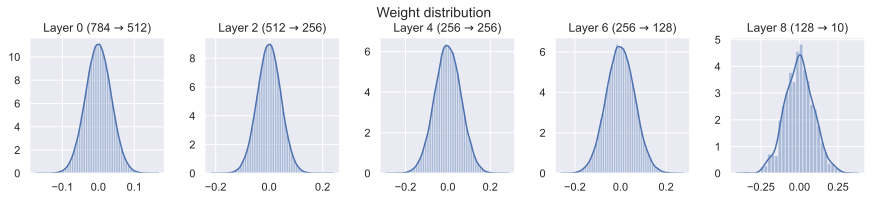

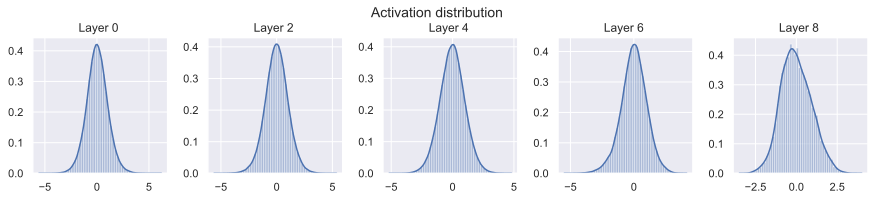

Layer 0 - Variance: 1.020319
Layer 2 - Variance: 1.049295
Layer 4 - Variance: 1.031418
Layer 6 - Variance: 1.025792
Layer 8 - Variance: 0.872356


In [14]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0/math.sqrt(param.shape[1]))
        
equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

As we expected, the variance stays indeed constant across layers. Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a mean of 0 and variance of $1/d$. You often see a uniform distribution being used for initialization. A small benefit of using a uniform instead normal distribution is that we can exclude the chance of initializing very large or small weights.

Besides the variance of the activations, another variance we would like to stabilize is the one of the gradients. This ensures a stable optimization for deep networks. It turns out that we can do the same calculation as above, and come to the conclusion that we should initialize our layers with $1/d_x$ where $d_y$ is the number of input neurons (you can do the calculation as a practice, it can be done in the exact same way as above). As a compromise between both constraints, [Glorot and Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi) proposed to use the harmonic mean of both values. This leads us to the well-known Xavier initialization:
$$W\sim \mathcal{N}\left(0,\frac{2}{d_x+d_y}\right)$$
If we use a uniform distribution, we would initialize the weights with:
$$W\sim U\left[-\frac{\sqrt{6}}{\sqrt{d_x+d_y}}, \frac{\sqrt{6}}{\sqrt{d_x+d_y}}\right]$$
Let's shortly implement it and validate its effectiveness:

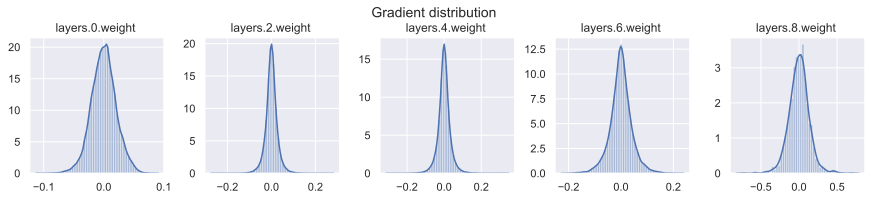

layers.0.weight - Variance: 0.000436
layers.2.weight - Variance: 0.000747
layers.4.weight - Variance: 0.001149
layers.6.weight - Variance: 0.001744
layers.8.weight - Variance: 0.017655


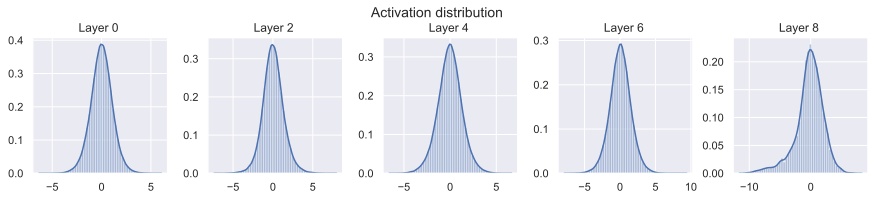

Layer 0 - Variance: 1.216592
Layer 2 - Variance: 1.719161
Layer 4 - Variance: 1.714506
Layer 6 - Variance: 2.224779
Layer 8 - Variance: 5.297660


In [15]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound, bound)
        
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

We see that the Xavier initialization balances the variance of gradients and activations. Note that the significantly higher variance for the output layer is due to large difference of input and output dimension ($128$ vs $10$). However, we currently assumed the activation function to be linear. So what happens if we add a non-linearity? In a tanh-based network, a common assumption is that for small values during the initial steps in training, the $\tanh$ works as a linear function such that we don't have to adjust our calculation. We can check if that is the case for us as well:

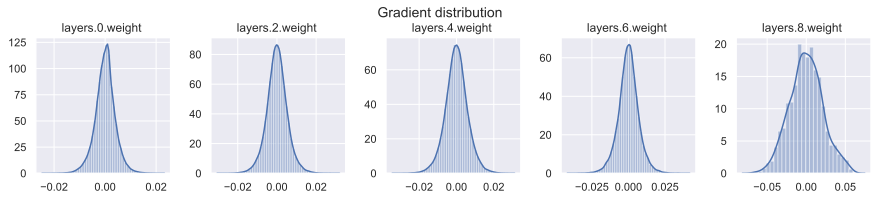

layers.0.weight - Variance: 0.000016
layers.2.weight - Variance: 0.000027
layers.4.weight - Variance: 0.000036
layers.6.weight - Variance: 0.000049
layers.8.weight - Variance: 0.000455


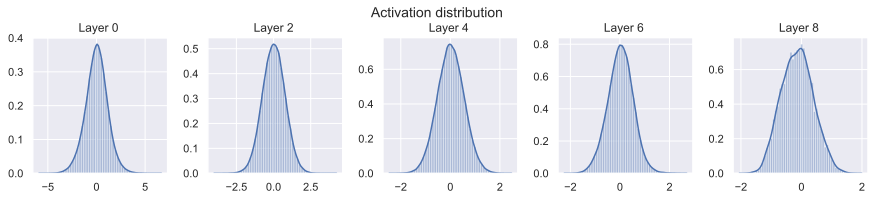

Layer 0 - Variance: 1.295969
Layer 2 - Variance: 0.583388
Layer 4 - Variance: 0.291432
Layer 6 - Variance: 0.265237
Layer 8 - Variance: 0.274929


In [16]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Although the variance decreases over depth, it is apparent that the activation distribution becomes more focused on the low values. Therefore, our variance will stabilize around 0.1 if we would go even deeper. Hence, Xavier initialization works well for Tanh networks. But what about ReLU networks? Here, we cannot take the previous assumption of the non-linearity becoming linear for small values. The ReLU activation function sets (in expectation) half of the inputs to 0, so that also the expectation of the input is not zero. However, as long as the expectation of $W$ is zero and $b=0$, the expectation of the output is zero. The variance is slightly changed, namely to $2/d_x$, which gives us the Kaiming initialization (see [He, K. et al. (2015)](https://arxiv.org/pdf/1502.01852.pdf)). Note that the Kaiming initialization does not use the harmonic mean between input and output size. In their paper (Section 2.2, Backward Propagation, last paragraph), they argue that using $d_x$ or $d_y$ both lead to stable gradients throughout the network, and only depend on the overall input and output size of the network. Hence, we can use here only the input $d_x$:

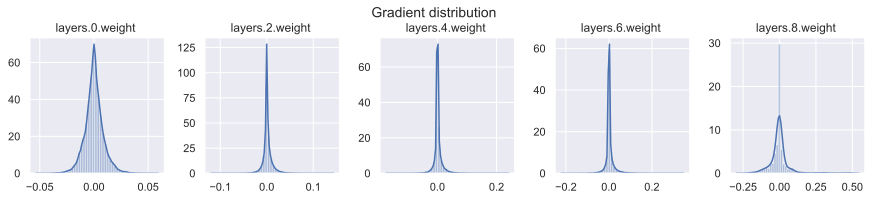

layers.0.weight - Variance: 0.000075
layers.2.weight - Variance: 0.000108
layers.4.weight - Variance: 0.000185
layers.6.weight - Variance: 0.000444
layers.8.weight - Variance: 0.005548


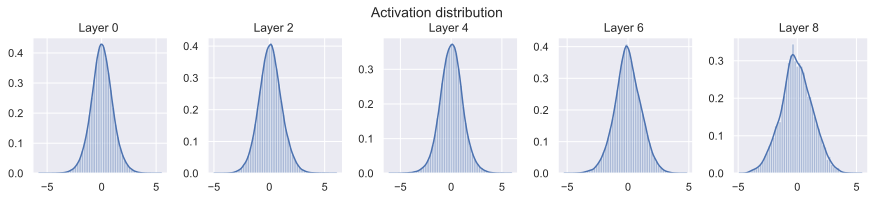

Layer 0 - Variance: 1.012342
Layer 2 - Variance: 1.092432
Layer 4 - Variance: 1.268176
Layer 6 - Variance: 1.193706
Layer 8 - Variance: 1.760064


In [17]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

The variance stays stable across layers. We can conclude that the Kaiming initialization indeed works well for ReLU-based networks. Note that for Leaky-ReLU etc., we have to slightly adjust the factor of $2$ in the variance as half of the values are not set to zero anymore. PyTorch provides a function to calculate this factor for many activation function, see [`torch.nn.init.calculate_gain`](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain).

## Optimization

In [18]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), "Could not find the config file \"%s\". Are you sure this is the correct path and you have your model config stored here?" % (config_file)
    assert os.path.isfile(model_file), "Could not find the model file \"%s\". Are you sure this is the correct path and you have your model stored here?" % (model_file)
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert act_fn_name in act_fn_by_name, "Unknown activation function \"%s\". Please add it to the \"act_fn_by_name\" dict."
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net
    
def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST
    
    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print("Model file already exists. Skipping training...")
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")
            
        # Defining optimizer, loss and data loader
        optimizer =  optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
    
        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ##############
            ## Training ##
            ##############
            net.train()
            TP, count = 0., 0
            t = tqdm(train_loader_local, leave=False)
            for imgs, labels in t:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                TP += (preds.argmax(dim=-1) == labels).sum().item()
                count += labels.shape[0]
                t.set_description("Epoch %i: loss=%4.2f" % (epoch+1, loss.item()))
                train_losses.append(loss.item())
            train_acc = TP / count
            train_scores.append(train_acc)

            ################
            ## Validation ##
            ################
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print("[Epoch %2i] Training accuracy: %05.2f%%, Validation accuracy: %05.2f%%" % (epoch+1, train_acc*100.0, val_acc*100.0))

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch
    
    if results is None:
        load_model(CHECKPOINT_PATH, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {"test_acc": test_acc, "val_scores": val_scores, "train_losses": train_losses, "train_scores": train_scores}
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)
            
    # Plot a curve of the validation accuracy
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"])
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.title("Validation performance of %s" % model_name)
    plt.show()
    plt.close()
    
    print((" Test accuracy: %4.2f%% " % (results["test_acc"]*100.0)).center(50, "=")+"\n")
    return results
    

def test_model(net, data_loader):
    """
    Test a model on a specified dataset.
    
    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    TP, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            TP += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = TP / count
    return test_acc 

In [19]:
class OptimizerTemplate:
    
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr
        
    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.zero_()
    
    @torch.no_grad()
    def step(self):
        for p in self.params:
            if p.grad is None:
                continue
            self.update_param(p)

SGD updates:
$$
\begin{split}
    g^{(t)} & = \nabla_{w^{(t-1)}} \mathcal{L}^{(t)} \\
    w^{(t)} & = w^{(t-1)} - \eta \cdot g^{(t)}
\end{split}
$$

In [20]:
class SGD(OptimizerTemplate):
    
    def __init__(self, params, lr):
        super().__init__(params, lr)
        
    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update)

SGD updates with momentum:
$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    w^{(t)} & = w^{(t-1)} - \eta \cdot m^{(t)}\\
\end{split}
$$

In [21]:
class SGDMomentum(OptimizerTemplate):
    
    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        
    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

As a reminder, the update formulas for Adam are as follows:
$$
\begin{split}
    m^{(t)} & = \beta_1 m^{(t-1)} + (1 - \beta_1)\cdot g^{(t)}\\
    v^{(t)} & = \beta_2 v^{(t-1)} + (1 - \beta_2)\cdot \left(g^{(t)}\right)^2\\
    \hat{m}^{(t)} & = \frac{m^{(t)}}{1-\beta^{t}_1}, \hat{v}^{(t)} = \frac{v^{(t)}}{1-\beta^{t}_2}\\
    w^{(t)} & = w^{(t-1)} - \frac{\eta}{\sqrt{v^{(t)}} + \epsilon}\circ \hat{m}^{(t)}\\
\end{split}
$$

In [22]:
class Adam(OptimizerTemplate):
    
    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params}
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        
    def update_param(self, p):
        self.param_step[p] += 1
        
        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]
        
        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]
        
        p_2nd_mom = (self.param_2nd_momentum[p] / bias_correction_2)
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * self.param_momentum[p]
        
        p.add_(p_update)

In [23]:
base_model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512,256,256,128])
kaiming_init(base_model)

Model file already exists. Skipping training...


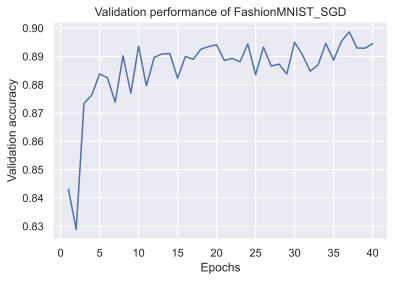

============= Test accuracy: 89.09% ==============



In [24]:
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(SGD_model, "FashionMNIST_SGD", 
                          lambda params: SGD(params, lr=1e-1), 
                          max_epochs=40, batch_size=256)

Model file already exists. Skipping training...


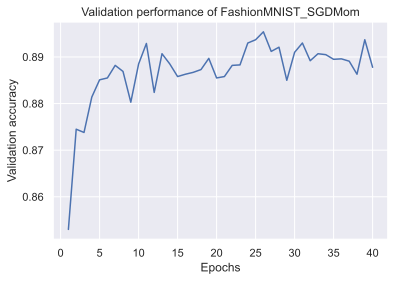

============= Test accuracy: 88.83% ==============



In [25]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(SGDMom_model, "FashionMNIST_SGDMom", 
                             lambda params: SGDMomentum(params, lr=1e-1, momentum=0.9), 
                             max_epochs=40, batch_size=256)

Model file already exists. Skipping training...


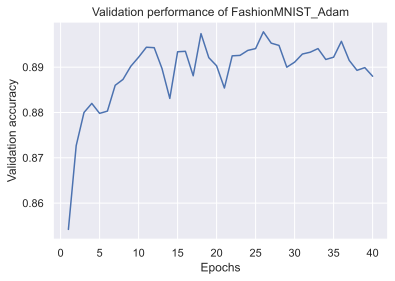

============= Test accuracy: 89.46% ==============



In [26]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(Adam_model, "FashionMNIST_Adam", 
                           lambda params: Adam(params, lr=1e-3), 
                           max_epochs=40, batch_size=256)

Result: all optimizers perform similarly well with a proper initialization. When changing the initialization to worse, Adam usually shows to be more robust. To show the specific benefits of the optimizers, we look at some possible loss surfaces below.

### Pathological curvatures

In [27]:
def pathological_curve_loss(w1, w2):
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

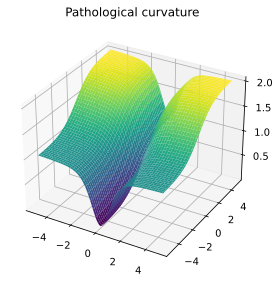

In [28]:
def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis):
    fig = plt.figure()
    ax = fig.gca(projection='3d') if plot_3d else fig.gca()
    
    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid([x,y])
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()
    
    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title("Pathological curvature")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In [29]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optim = optimizer_func([weights])
    
    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optim.zero_grad()
        loss.backward()
        optim.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

In [30]:
SGD_points = train_curve(lambda params: SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
Adam_points = train_curve(lambda params: Adam(params, lr=1))

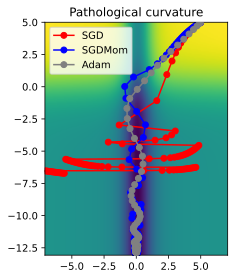

In [31]:
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=1, label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=3, label="Adam")
plt.legend()
plt.show()

### Steep gradients

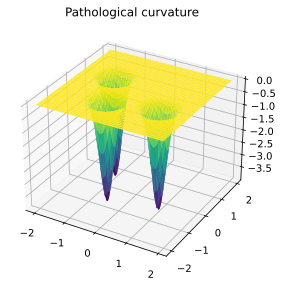

In [32]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * torch.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z

_ = plot_curve(comb_func, x_range=(-2,2), y_range=(-2,2), plot_3d=True)

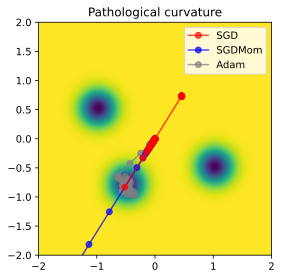

In [33]:
SGD_points = train_curve(lambda params: SGD(params, lr=.5), comb_func, init=[0,0])
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=1, momentum=0.9), comb_func, init=[0,0])
Adam_points = train_curve(lambda params: Adam(params, lr=1), comb_func, init=[0,0])

all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(comb_func,
                x_range=(-2, 2),
                y_range=(-2, 2),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()

## Conclusion

## References